# Hotspot analysis

In [ ]:
import os
import geopandas as gpd
import pandas as pd
import shapely as shp
from shapely.geometry import Point
import libpysal as pslib
import os
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import pysal.explore as psesda
import random


In [ ]:
#This function counts by the well location and merges with shapefile
def count_by_location(df, poly, merge_col_name, out_col_name):
    df_join = gpd.sjoin(poly,df) #Spatial join Points to polygons
    vc = df_join[merge_col_name].value_counts()
    vc_df = vc.rename_axis(merge_col_name).to_frame(out_col_name)
    df_merge = poly.merge(vc_df,how='left',on=merge_col_name)
    df_merge[out_col_name] = df_merge[out_col_name].fillna(0)
    return df_merge

In [18]:
#Set data directory
dat_dir = r'ENTER DATA DIRECTORY'
dataset_name = 'ENTER NAME'
grid_shp_name = 'ENTER NAME'

#Load dataset
df = pd.read_csv(os.path.join(dat_dir,dataset_name), low_memory=False)


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df['Longitude'], y=df['Latitude']))
gdf.crs = {"init":"epsg:4326"}
gdf = gdf.to_crs(epsg=4326)
grid = gpd.read_file(os.path.join(dat_dir, grid_shp_name))
grid = grid.to_crs(epsg=4326)
grid['sec_id'] = grid.index

Index(['Shape_Leng', 'Shape_Area', 'GRID_ID', 'geometry', 'sec_id'], dtype='object')

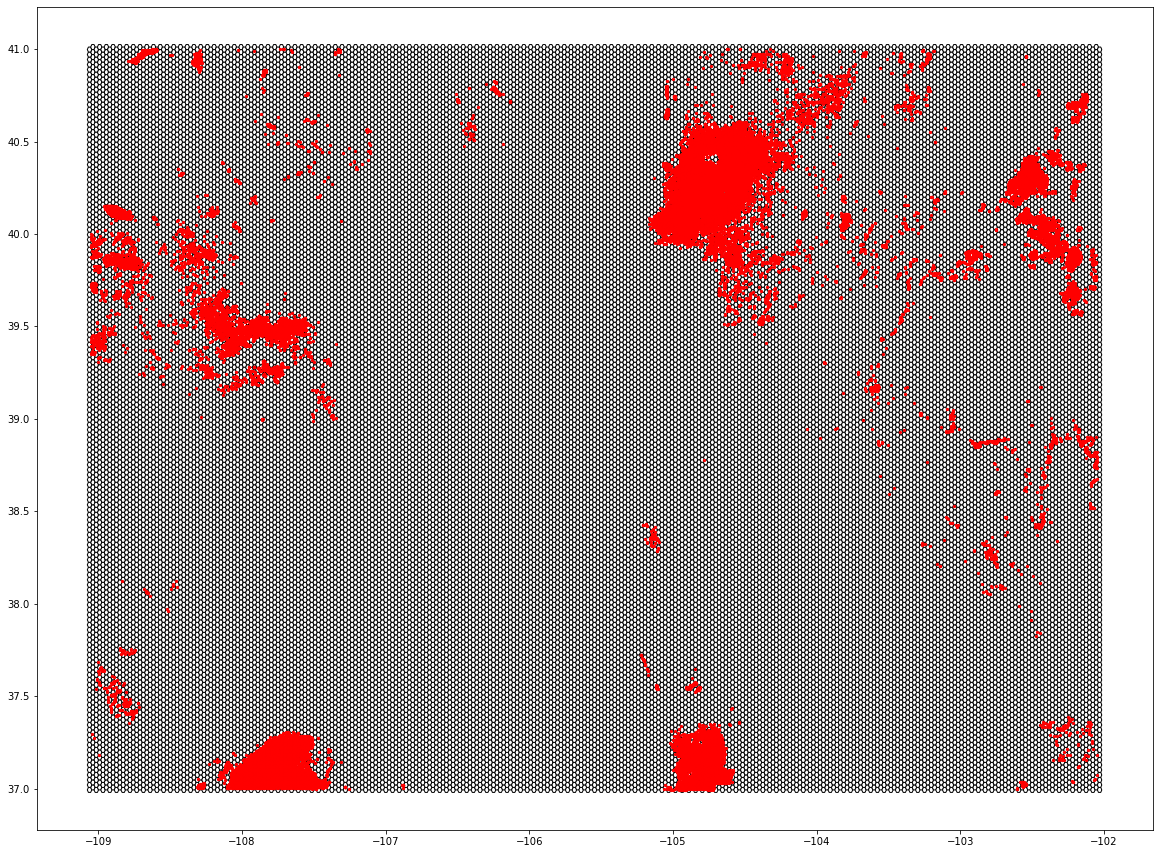

In [20]:
#Check basic map
base = grid.plot(color='white', edgecolor='black', figsize=(20, 20))

gdf.plot(ax=base, marker='o', color='red', markersize=5)
grid.columns


In [22]:
# count number of records inside grid
record_counts = None
record_counts = count_by_location(gdf,grid,'sec_id','tested')
record_counts = count_by_location(gdf[gdf['field_of_interest']==True], record_counts,'sec_id','field_to_check')
record_counts['p_field_to_check'] = np.around((record_counts['field_to_check']/record_counts['tested'])*100,2)
record_counts['p_field_to_check'] = record_counts['p_field_to_check'].fillna(0)


<AxesSubplot:>

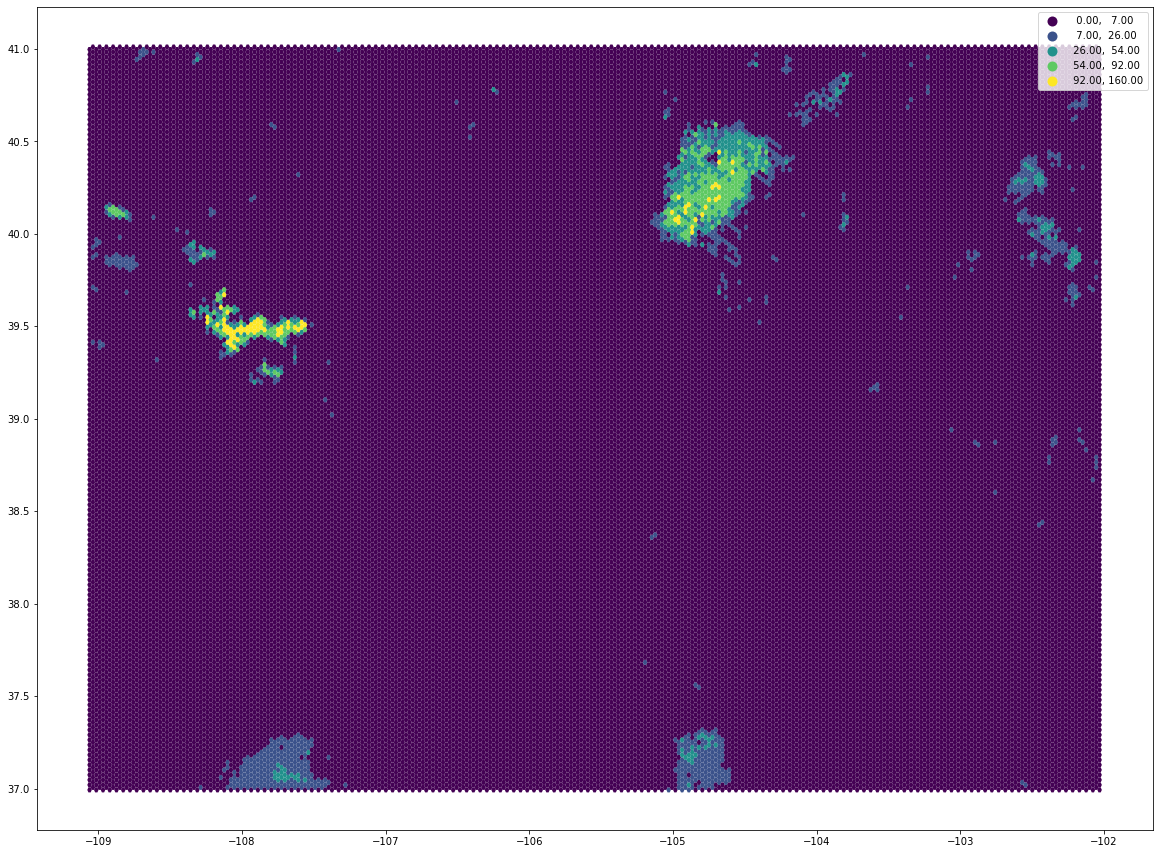

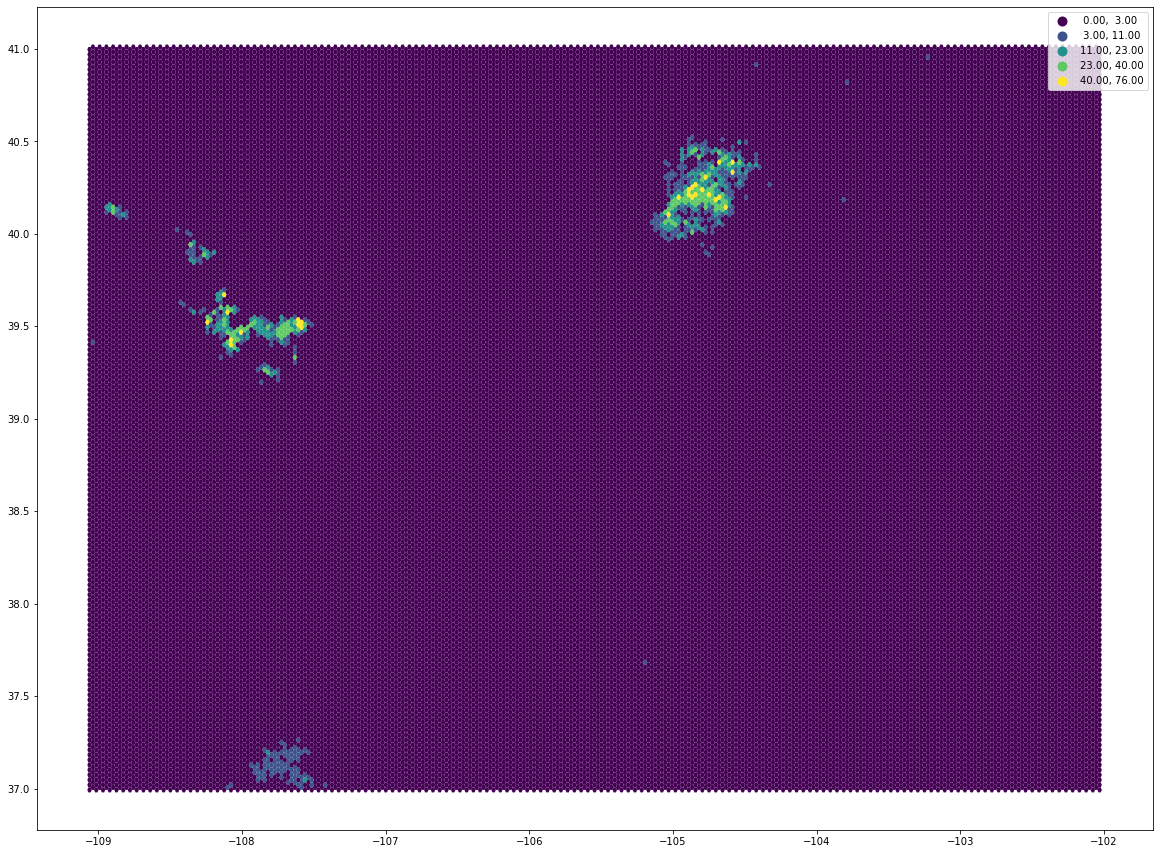

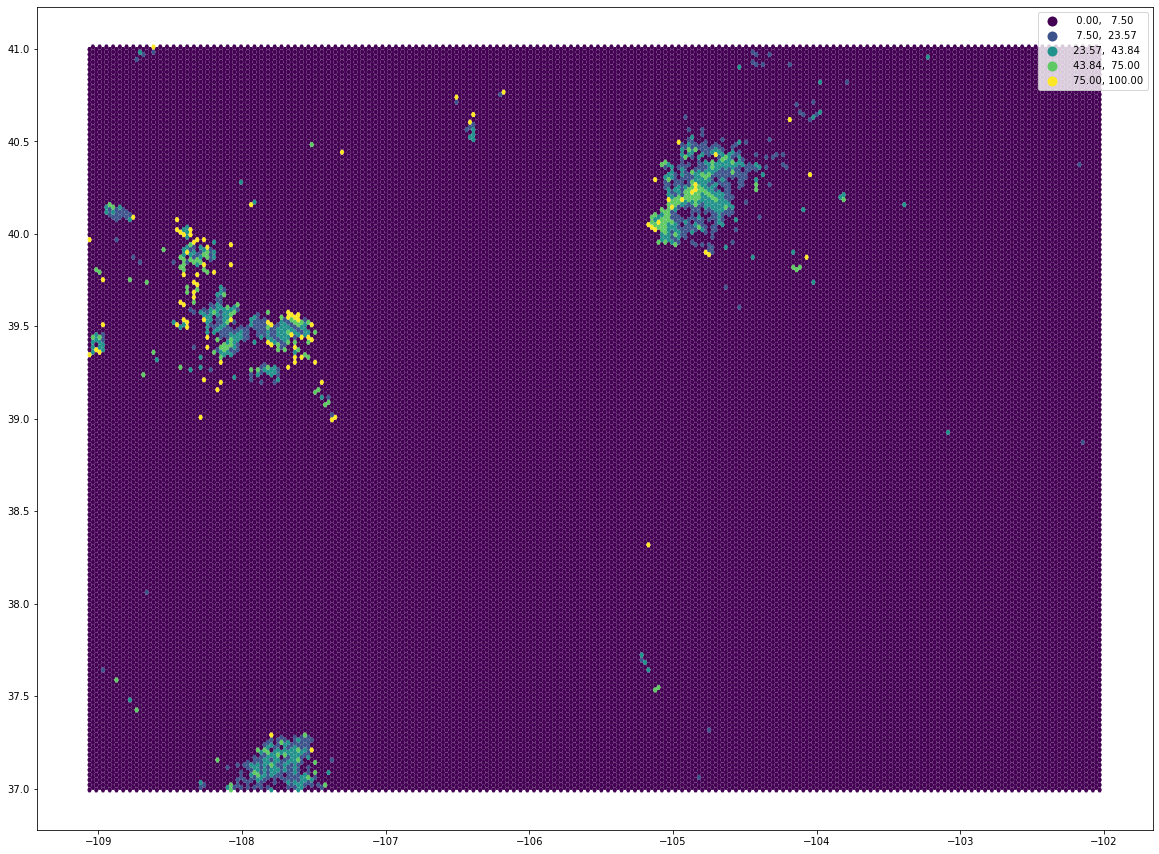

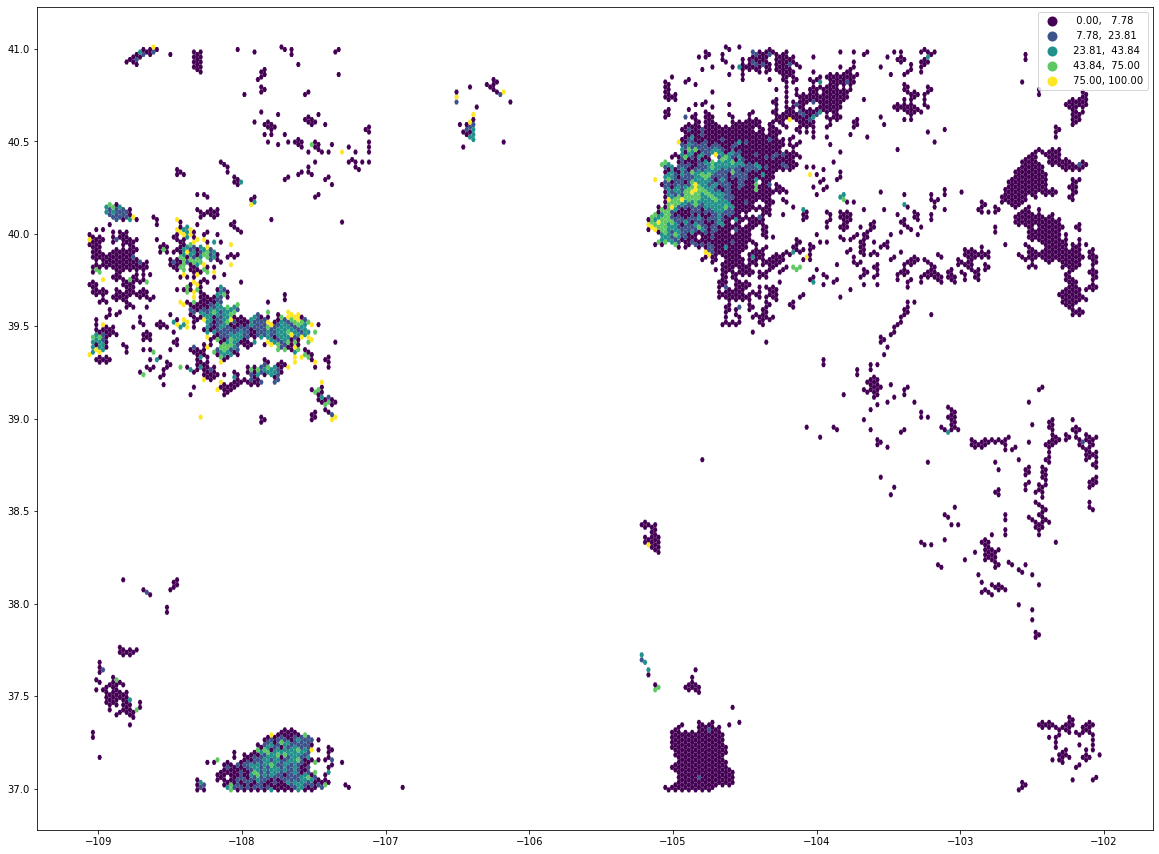

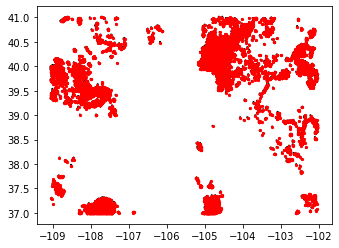

In [23]:
# Plot record counts
record_counts.plot(
     column="tested",
     legend=True,
     scheme="fisher_jenks",
     figsize=(20,20)
);
record_counts.plot(
     column="field_to_check",
     legend=True,
     scheme="fisher_jenks",
     figsize=(20,20)
);

record_counts.plot(
     column="p_field_to_check",
     legend=True,
     scheme="fisher_jenks",
     figsize=(20,20)
);


wswc_filt = record_counts[record_counts['tested']>0]

wswc_filt.plot(
     column="p_field_to_check",
     legend=True,
     scheme="fisher_jenks",
     figsize=(20,20)
);

#Check basic map
base = wswc_filt.plot(color='white', edgecolor='black')

gdf.plot(ax=base, marker='o', color='red', markersize=5)





In [25]:
#Create copies and convert the copies - no need to project
wswc_filt_copy = wswc_filt.copy()
wswc_sw = pslib.weights.Queen.from_dataframe(wswc_filt_copy) 



In [26]:
# count number of neighbors
counts = []
n=[]
for i in wswc_sw.neighbors:
    counts.append(len(wswc_sw.neighbors[i]))
    n.append(i)
count_n = pd.DataFrame(
    {'section': n,
     'num_neighbors': counts
    })
count_n.num_neighbors.value_counts()

6    1352
4     546
5     537
3     527
2     494
1     314
0     215
Name: num_neighbors, dtype: int64

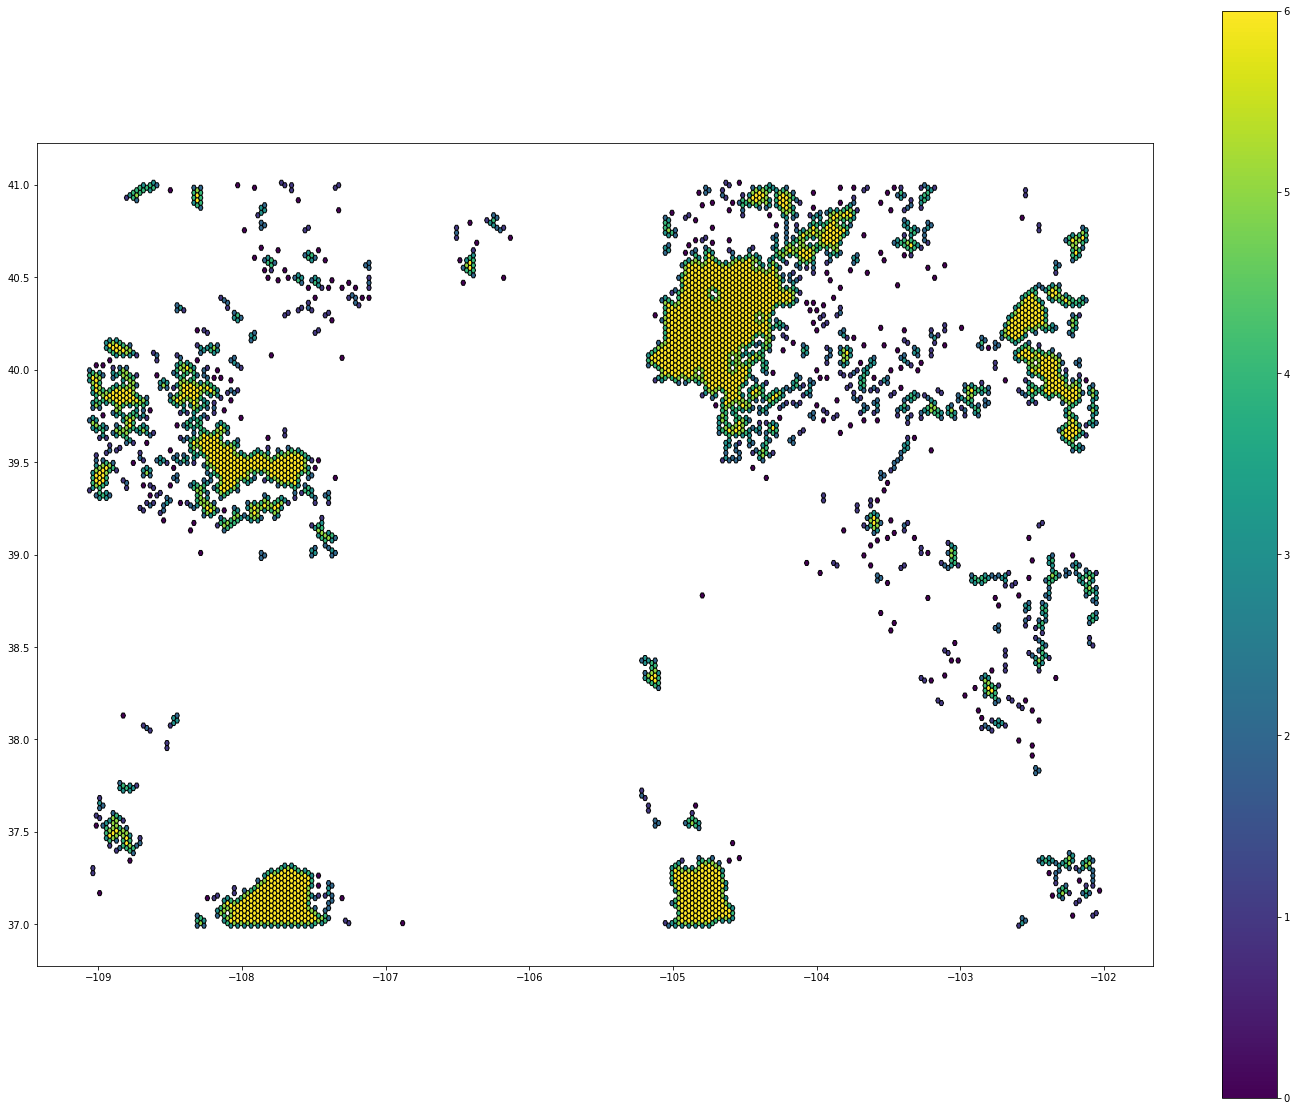

In [27]:
# plot number of neighbors
wswc_filt_copy.shape[0]
wswc_filt_copy['num_neighbors'] = counts
base = wswc_filt_copy.plot(column='num_neighbors', legend = True,edgecolor='black',figsize=(25, 20))

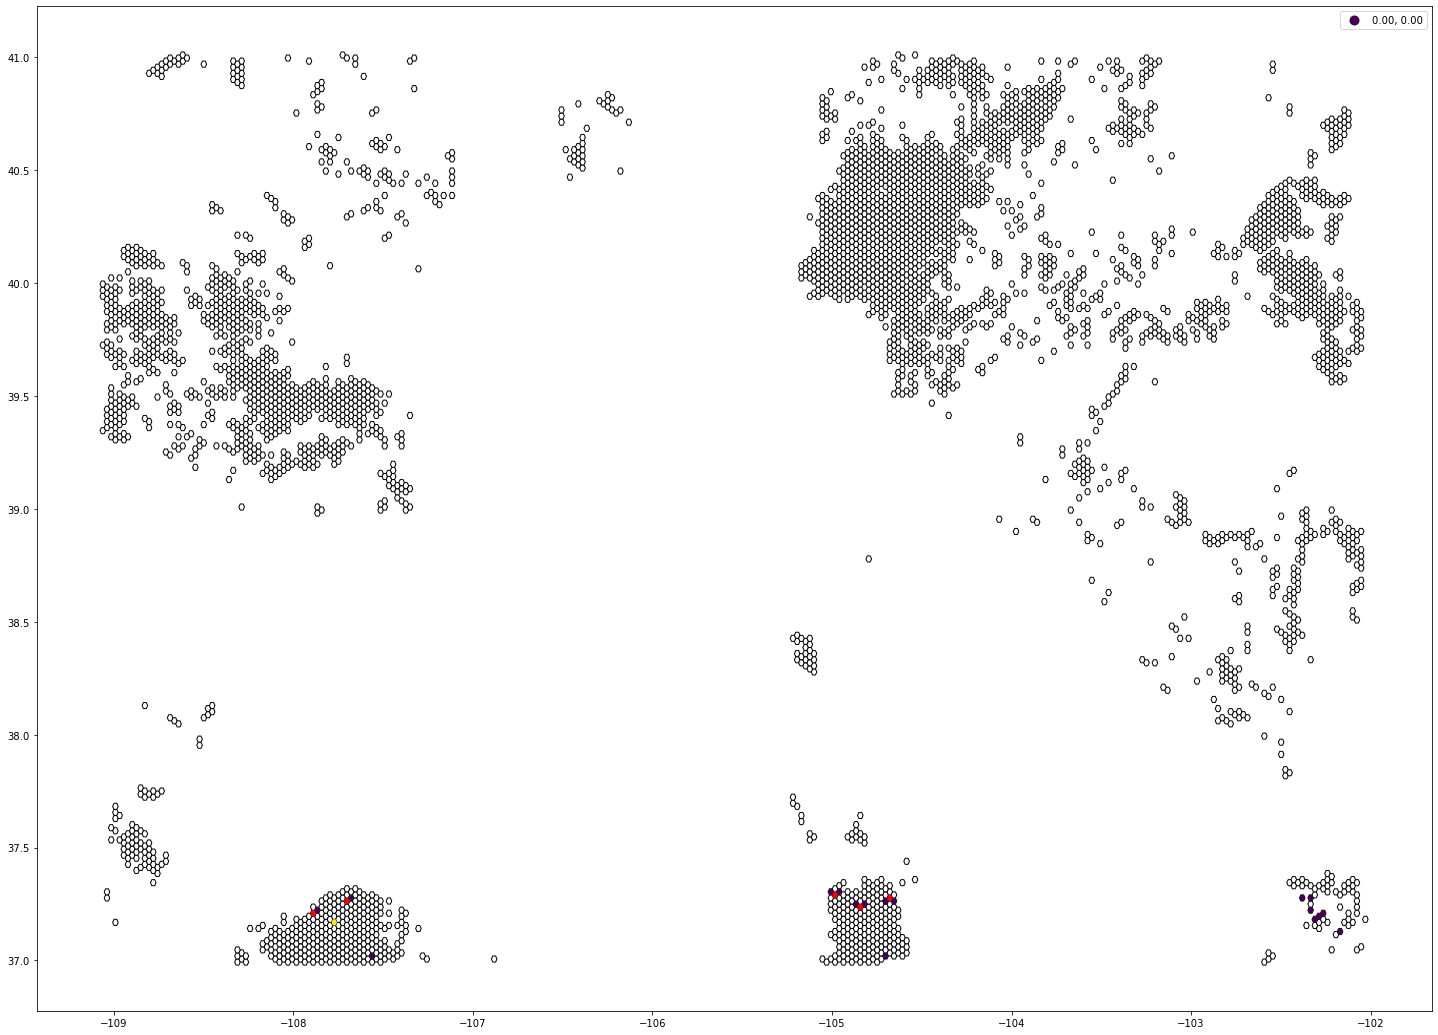

In [28]:
#Check the neighbors and make sure they align with what we are looking for:

base = wswc_filt.plot(color='white', edgecolor='black',figsize=(25, 20))

wswc_sw.neighbors.keys()
index_list = random.choices(list(wswc_sw.neighbors.keys()), k=30)

for idx in index_list:

    wswc_filt_copy[wswc_filt_copy.sec_id.isin(wswc_sw.neighbors[idx])].plot(
         column="p_field_to_check",
         legend=True,
         scheme="quantiles",
         ax=base
    );

    wswc_filt_copy[wswc_filt_copy.sec_id.isin([idx])].plot(
         column="p_field_to_check",
         legend=True,
         scheme="quantiles",
         color='red',

         ax=base
    );





### Dealing with islands

Approach 1: remove sections with no neighbors 

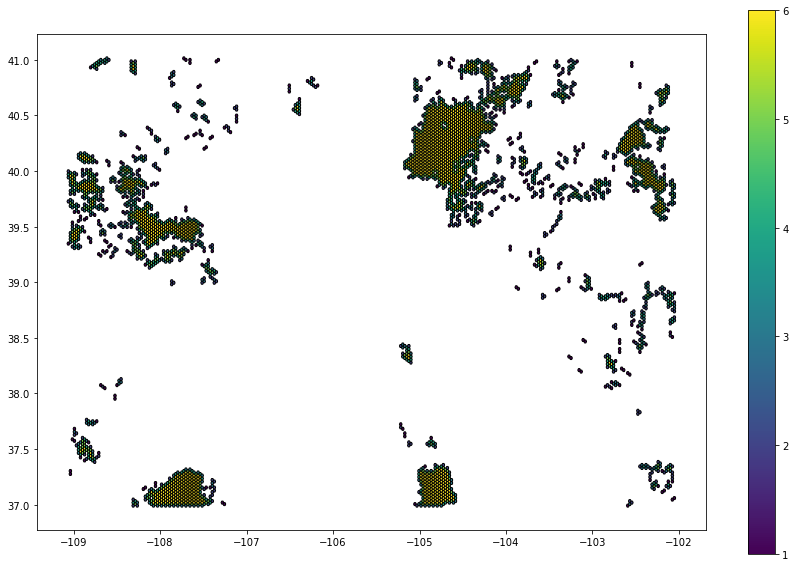

In [30]:
wswc_filt_no_isl = wswc_filt_copy[wswc_filt_copy['num_neighbors']>0]
wswc_sw2 = pslib.weights.Queen.from_dataframe(wswc_filt_no_isl) 


counts = []
n=[]
for i in wswc_sw2.neighbors:
    counts.append(len(wswc_sw2.neighbors[i]))
    n.append(i)
count_n = pd.DataFrame(
    {'section': n,
     'num_neighbors': counts
    })
count_n.num_neighbors.value_counts()
wswc_filt_no_isl.shape[0]
wswc_filt_no_isl['num_neighbors'] = counts

base = wswc_filt_no_isl.plot(column='num_neighbors', legend = True,edgecolor='black',figsize=(15, 10))


In [31]:
#Calculate spatial lag
wswc_filt_no_isl.loc[:, 'sl_perc_field'] = pslib.weights.lag_spatial(wswc_sw2, wswc_filt_no_isl.p_field_to_check)

#Calculate G statistic
wswc_perc_field_G = psesda.esda.G(wswc_filt_no_isl['p_field_to_check'].values, wswc_sw2)
wswc_perc_field_GL = psesda.esda.G_Local(wswc_filt_no_isl['p_field_to_check'].values, wswc_sw2, star = True) #, star = True

#Identify significant rows for each value of inerest
#Using a p_value limit of 5% for now
p_value_lim = 0.05

#Create empty false columns
wswc_filt_no_isl.loc[:,'g_sig_perc_field'] = False
#Identify significant rows
wswc_filt_no_isl.loc[(wswc_perc_field_GL.p_sim < p_value_lim),'g_sig_perc_field'] = True

wswc_filt_no_isl.loc[:, 'g_z_perc_field'] = wswc_perc_field_GL.z_sim 
wswc_filt_no_isl.loc[:, 'g_p_perc_field'] = wswc_perc_field_GL.p_sim 


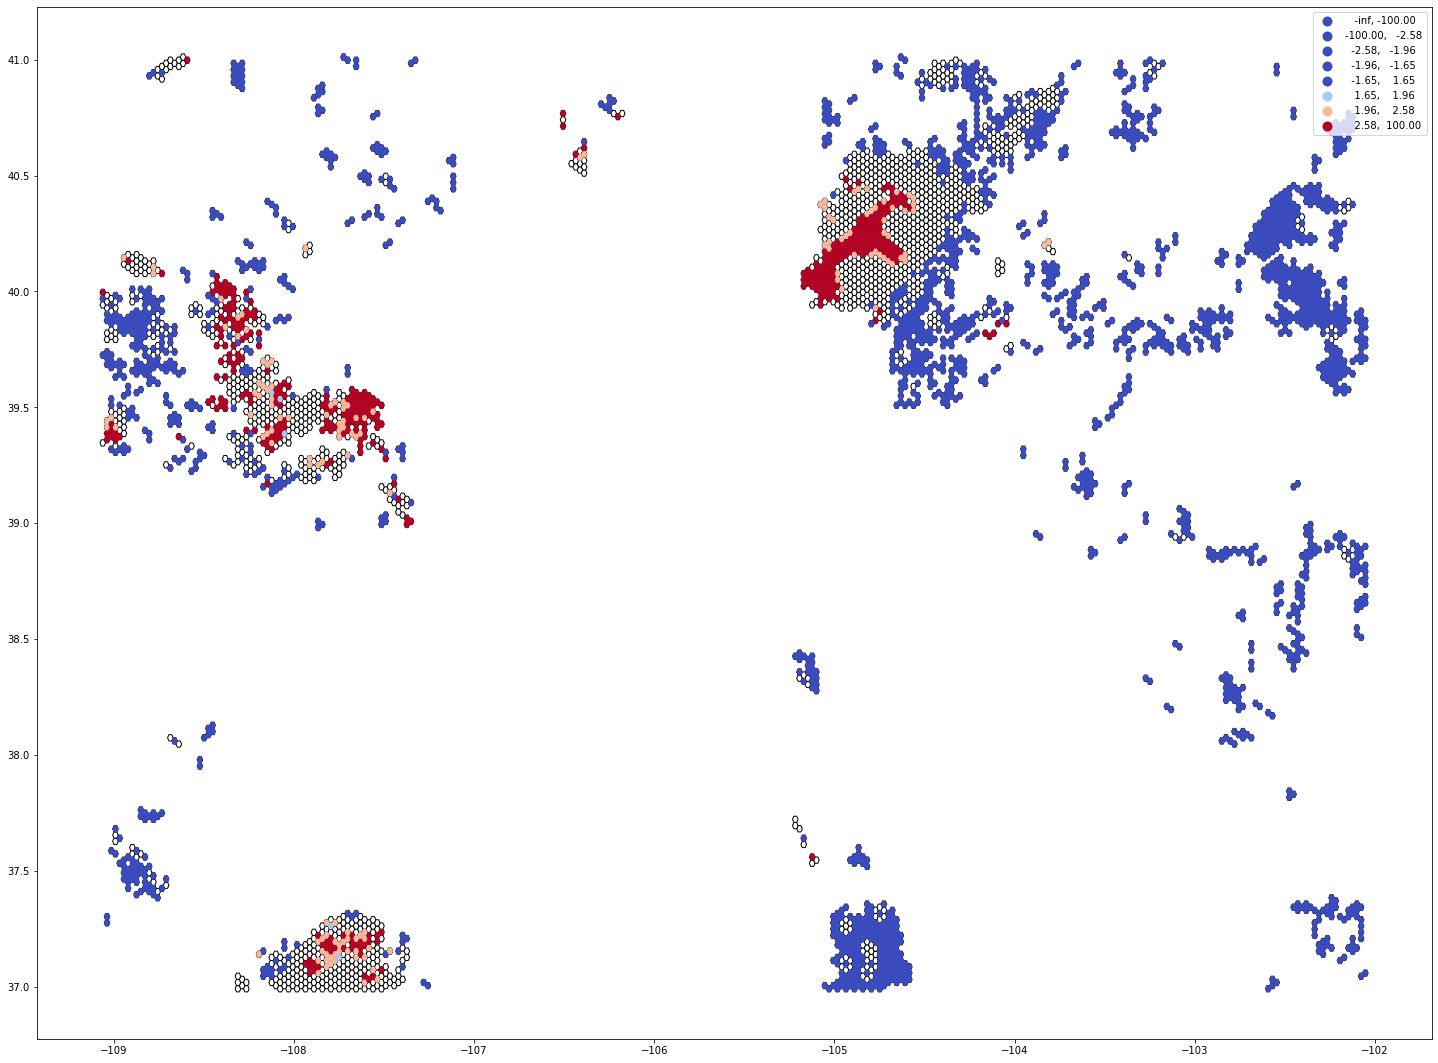

In [33]:
#Plot z value
base = wswc_filt_no_isl.plot(color='white', edgecolor='black',figsize=(25, 20))

wswc_filt_no_isl[wswc_filt_no_isl['g_sig_perc_field']==True].plot(
     column="g_z_perc_field",
     legend=True,
     scheme="User_Defined",
     ax=base,
     cmap='coolwarm',
     classification_kwds=dict(bins=[-100,-2.58, -1.96, -1.65,1.65, 1.96, 2.58, 100])
);

wswc_filt_no_isl[wswc_filt_no_isl['g_sig_perc_field']==True].to_file(('ENTER NAME.shp'))
wswc_filt_no_isl.to_file(('ENTER NAME.shp'))


wswc_filt_no_isl_sig = wswc_filt_no_isl[wswc_filt_no_isl['g_sig_perc_field']==True]

wswc_filt_no_isl_sig.plot(
    
    
     column="g_z_perc_field",
     legend=True,
     scheme="User_Defined",
     ax=base,
     cmap='coolwarm',
     classification_kwds=dict(bins=[-100,-2.58, -1.96, -1.65,1.65, 1.96, 2.58, 100])
);

fig = base.get_figure()


